In [27]:

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
IPythonConsole.ipython_useSVG=False  #< set this to False if you want PNGs instead of SVGs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import numpy as np
from rdkit import DataStructs
from sklearn.decomposition import PCA

In [2]:
drugex_base_smiles = pd.read_csv("../data/drugex_selfies_base_80k.csv", header=None)
drugex_base_smiles = drugex_base_smiles[0].to_list()

In [3]:
drugex_base_smiles = list(set(drugex_base_smiles))

In [28]:
len(drugex_base_smiles)

16629

In [4]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

In [5]:
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int_)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [6]:
chembl_ligands = pd.read_csv("../data/ligand_raw.tsv", sep="\t", usecols=["Smiles", "Target_ChEMBL_ID", "pChEMBL_Value"])

In [7]:
df = chembl_ligands.query("`Target_ChEMBL_ID` == 'CHEMBL251'").dropna(subset=["Smiles"]) # ["Smiles"].to_list()

In [8]:
df["is_active"] = df["pChEMBL_Value"] >= 6.5

In [11]:
fp_list = fp_list_from_smiles_list(df.Smiles)

  0%|          | 0/13004 [00:00<?, ?it/s]

In [12]:
pca = PCA(n_components=2)
crds = pca.fit_transform(fp_list)

In [13]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
crds_df['is_active'] = list(df.is_active)
crds_df.head()

,PC_1,PC_2,is_active
0,0.311548,-0.624623,False
1,0.428978,-0.767733,False
2,-1.763289,1.083316,False
3,-1.631557,0.964515,False
4,-1.729357,1.252596,False


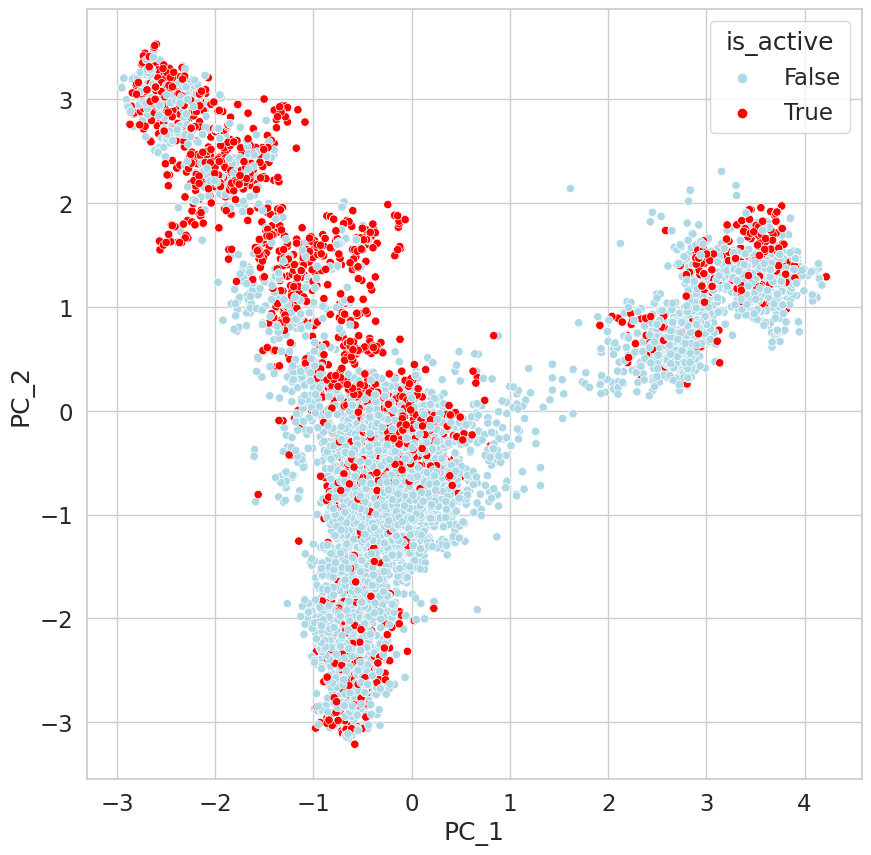

In [14]:
ax = sns.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="is_active",palette={0:'lightblue',1:'red'})

In [15]:
drugex_base_fp_list = fp_list_from_smiles_list(drugex_base_smiles)

  0%|          | 0/16629 [00:00<?, ?it/s]

In [16]:
final_fp_list = fp_list + drugex_base_fp_list

In [17]:
hue_list = df.is_active.astype(int).to_list() + [2 for _ in range(len(drugex_base_smiles))]

In [18]:
pca = PCA(n_components=2)
fcrds = pca.fit_transform(final_fp_list)
fcrds_df = pd.DataFrame(fcrds,columns=["PC_1","PC_2"])
fcrds_df['is_active'] = hue_list
fcrds_df.head()

,PC_1,PC_2,is_active
0,0.558491,-0.195945,0
1,0.540201,-0.418400,0
2,-0.726573,1.614437,0
3,-0.238091,1.734378,0
4,-0.570056,1.793163,0


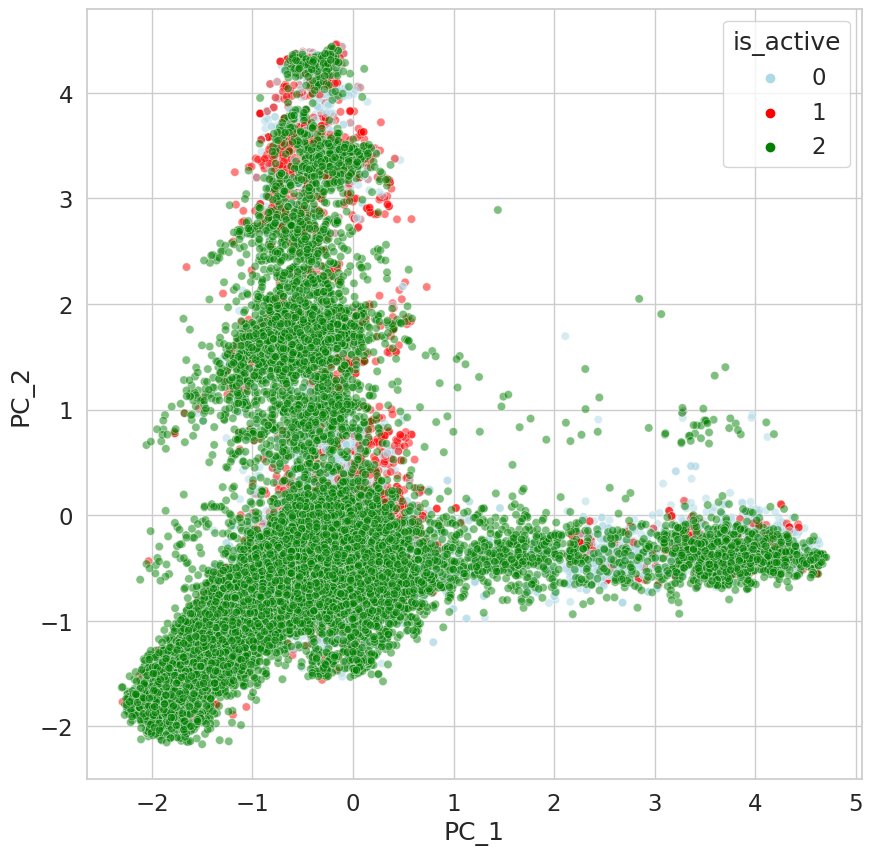

In [19]:
fax = sns.scatterplot(data=fcrds_df,x="PC_1",y="PC_2",hue="is_active",palette={0:'lightblue',1:'red',2:'green'}, alpha=0.5)

In [20]:
pca = PCA(n_components=50)
fcrds = pca.fit_transform(final_fp_list) 

In [21]:
from sklearn.manifold import TSNE
%time crds_embedded = TSNE(n_components=2).fit_transform(fcrds)

/home/julius/miniconda3/envs/gflownet/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/julius/miniconda3/envs/gflownet/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 7min 55s, sys: 2.32 s, total: 7min 58s
Wall time: 51.3 s


In [22]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['is_active'] = hue_list

Text(0.5, 1.0, 'Chemical space $A_{2A}AR$ ChEMBL ligands vs. generated by DrugEx+R')

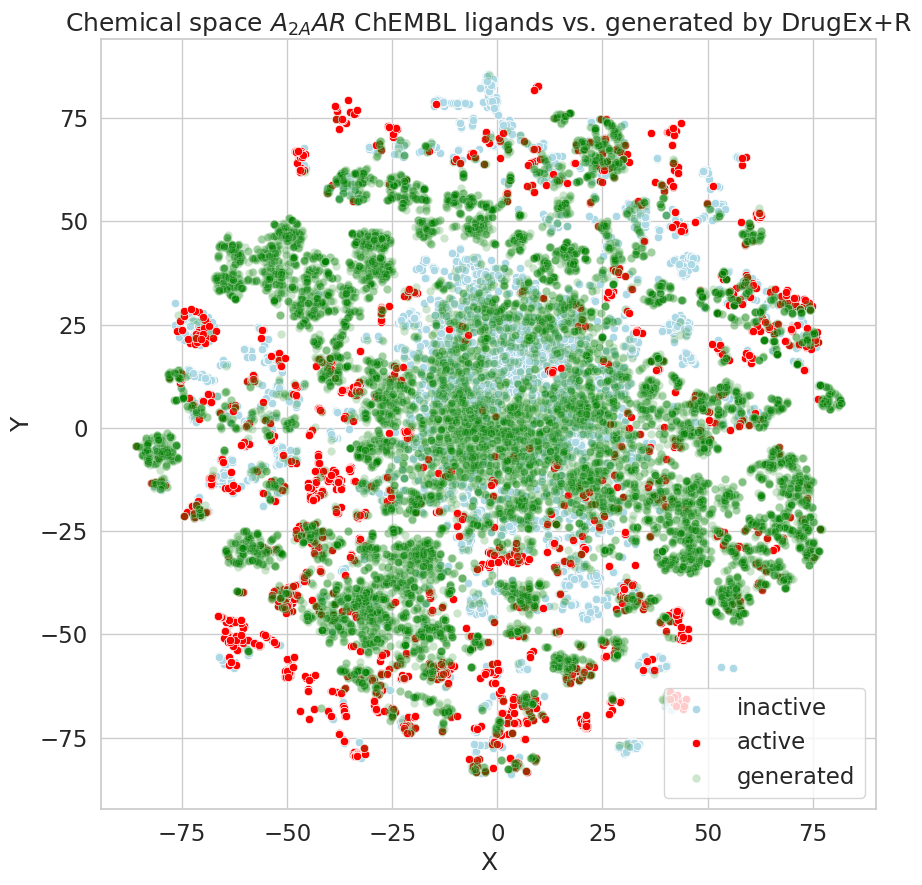

In [26]:
ax = sns.scatterplot(data=tsne_df.query("is_active == 0"),x="X",y="Y",color='lightblue')
ax = sns.scatterplot(data=tsne_df.query("is_active == 1"),x="X",y="Y",color='red')
ax = sns.scatterplot(data=tsne_df.query("is_active == 2"),x="X",y="Y",color='green', alpha=0.2)
ax.legend(labels=['inactive', 'active', 'generated'], loc="lower right")
ax.set_title("Chemical space $A_{2A}AR$ ChEMBL ligands vs. generated by DrugEx+R")
# plt.savefig("../reports/a2a_drugex_plus_r_drugex_base_task_chemical_space_tsne_50comp.png")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    fig = None
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    if fig:
        cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
        cbar.ax.set_ylabel('Density')

    return ax

In [ ]:
density_scatter(x=crds_df["PC_1"], y=crds_df["PC_2"], bins=100, cmap=cm.jet)